**Experiment Description:**   
- **Purpose:** Evaluate the impact of proportions of inliers in the training data
- **Experimental Design:** Range the proportion of type 1 inliers in test data from 0.001 to 0.999, change the proportion of type 1 inliers in training data from 0.05 to 0.95.
- **Methods:** Proportion Estimation Free(PE Free); Classification, Mixture Model using Normal Fitting and Gamma Fitting
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Data Shapes:** Uniform + Normal, with 50 dimensions
- **Size of Training Data:** 700
- **Size of Calibration Data:** [500, 500]
- **Size of Test Data:** 900 inliers and 100 outliers
  
- **Times of Iteration**: 10

Conclusion:
PE free methods depends highly on inlier proportions in the training data, only when inlier proprotions equal to half-half, PE free methods could have a high power

**Final Conclusion:** The only factor influncing PE method using mixture model is the size of training data(num of the least one type inliers in trainin g data, to be more precise)

### Setup

In [22]:
# This helPE when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
import pomegranate
import torch
from pomegranate.distributions import *

np.set_printoptions(suppress=True)
%load_ext watermark
%watermark -m -n -p numpy,torch,pomegranate

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores,prepare_pu_score_matrices
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power, compute_standard_conformal_scores, train_occ, scale_data
from mypackage.proportion_estimation import adjust_proportions, compute_mean_distance, adjust_proportions_mixture_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.26.4
torch      : 2.4.0
pomegranate: 1.1.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



## Data Generation

In [71]:
np.random.seed(0)

# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 4

# Training, Calibration, and Test data
num_in_train = 700
n_in_cal = [500, 500]
num_in_test = 900
n_in_test = [1499, 1]
n_out_test = 100
n_test = num_in_test + n_out_test

# Range of rho values
rho_values_test = [0.001, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95, 0.999]
rho_values_train = [0.05 ,0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 0.95]

# Monte Carlo iterations
num_iterations = 10

## Preparation

In [72]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# Define machine learning models
binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

In [73]:
# Store results
mean_fdr = {rho_value_train: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for rho_value_train in rho_values_train}
ci_fdr = {rho_value_train: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for rho_value_train in rho_values_train}
mean_power = {rho_value_train: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for rho_value_train in rho_values_train}
ci_power = {rho_value_train: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for rho_value_train in rho_values_train}

### PU Learning

In [74]:
for rho_value_train in rho_values_train:
    # Train samples
    n_in_train = [int(rho_value_train * num_in_train)] + [(num_in_train - int(rho_value_train * num_in_train)) // (K - 1)] * (K - 1)
    
    # Adjust remaining train samples
    remaining_train_samples = num_in_train - sum(n_in_train)
    for i in range(remaining_train_samples):
        n_in_train[1 + i % (K - 1)] += 1
    
    for rho_value_test in rho_values_test:
        # Test samples
        n_in_test = [int(rho_value_test * num_in_test)] + [(num_in_test - int(rho_value_test * num_in_test)) // (K - 1)] * (K - 1)
        
        # Adjust remaining test samples
        remaining_test_samples = num_in_test - sum(n_in_test)
        for i in range(remaining_test_samples):
            n_in_test[1 + i % (K - 1)] += 1
    
        fdr_PE_free_vec = []
        fdr_classification_vec = []
        fdr_normal_vec = []
        fdr_gamma_vec = []
        power_PE_free_vec = []
        power_classification_vec = []
        power_normal_vec = []
        power_gamma_vec = []
    
        for _ in range(num_iterations):
            # Generate initial training, calibration, and test data
            X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
            X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
            X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)

            # Get a list of OCC
            X_train_scaled = scale_data(X_train, X_train)
            occ_list = train_occ(K, X_train_scaled, Y_train, oneclass_classifier)
    
            # Adjust the proportions in the training data
            X_train_classification, Y_train_classification = adjust_proportions(K, X_train, Y_train, X_cal, X_test, occ_list, method='subsample')
            X_train_normal, Y_train_normal  = adjust_proportions_mixture_model(K, X_train, Y_train, X_cal, X_test, occ_list, sample_method='subsample', mixture_distributions = 'normal')
            X_train_gamma, Y_train_gamma = adjust_proportions_mixture_model(K, X_train, Y_train, X_cal, X_test, occ_list, sample_method='subsample', mixture_distributions = 'gamma')
    
            # Compute PU scores
            scores_cal_PE_free, scores_test_PE_free= compute_pu_scores(
                K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, 'multi_step')
            
            scores_cal_classification, scores_test_classification = compute_pu_scores(
                K, X_train_classification, Y_train_classification, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, 'two_step')
    
            scores_cal_normal, scores_test_normal = compute_pu_scores(
                K, X_train_normal, Y_train_normal, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, 'two_step')
    
            scores_cal_gamma, scores_test_gamma = compute_pu_scores(
                K, X_train_gamma, Y_train_gamma, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, 'two_step')
    
            # transform the format of scores
            scores_cal_mat_PE_free, scores_test_mat_PE_free = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_PE_free, scores_test_PE_free)
            
            scores_cal_mat_classification, scores_test_mat_classification = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_classification, scores_test_classification)
            
            scores_cal_mat_normal, scores_test_mat_normal = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_normal, scores_test_normal)
            
            scores_cal_mat_gamma, scores_test_mat_gamma = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_gamma, scores_test_gamma)
    
            # Compute MAMCOD conformal p-values
            MAMCOD_pv_PE_free = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_PE_free, scores_test_mat_PE_free, is_high_score_inlier = False)
            MAMCOD_pv_classification = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_classification, scores_test_mat_classification, is_high_score_inlier = False)
            MAMCOD_pv_normal = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_normal, scores_test_mat_normal, is_high_score_inlier = False)
            MAMCOD_pv_gamma = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_gamma, scores_test_mat_gamma, is_high_score_inlier = False)
            
            # Compute FDR and Power by BH procedure
            fdr_PE_free, power_PE_free = compute_fdr_power(MAMCOD_pv_PE_free, Y_test, alpha = 0.1)
            fdr_classification, power_classification = compute_fdr_power(MAMCOD_pv_classification, Y_test, alpha = 0.1)
            fdr_normal, power_normal = compute_fdr_power(MAMCOD_pv_normal, Y_test, alpha = 0.1)
            fdr_gamma, power_gamma = compute_fdr_power(MAMCOD_pv_gamma, Y_test, alpha = 0.1)
            
            fdr_PE_free_vec.append(fdr_PE_free)
            fdr_classification_vec.append(fdr_classification)
            fdr_normal_vec.append(fdr_normal)
            fdr_gamma_vec.append(fdr_gamma)
            power_PE_free_vec.append(power_PE_free)
            power_classification_vec.append(power_classification)
            power_normal_vec.append(power_normal)
            power_gamma_vec.append(power_gamma)    

        # Calculate mean FDR and Power
        mean_fdr[rho_value_train]['PE_free'].append(np.mean(fdr_PE_free_vec))
        mean_fdr[rho_value_train]['classification'].append(np.mean(fdr_classification_vec))
        mean_fdr[rho_value_train]['normal'].append(np.mean(fdr_normal_vec))
        mean_fdr[rho_value_train]['gamma'].append(np.mean(fdr_gamma_vec))
    
        mean_power[rho_value_train]['PE_free'].append(np.mean(power_PE_free_vec))
        mean_power[rho_value_train]['classification'].append(np.mean(power_classification_vec))
        mean_power[rho_value_train]['normal'].append(np.mean(power_normal_vec))
        mean_power[rho_value_train]['gamma'].append(np.mean(power_gamma_vec))
    
        # Compute the standard deviation    
        ci_fdr[rho_value_train]['PE_free'].append((np.percentile(fdr_PE_free_vec, 5), np.percentile(fdr_PE_free_vec, 95)))
        ci_fdr[rho_value_train]['classification'].append((np.percentile(fdr_classification_vec, 5), np.percentile(fdr_classification_vec, 95)))
        ci_fdr[rho_value_train]['normal'].append((np.percentile(fdr_normal_vec, 5), np.percentile(fdr_normal_vec, 95)))
        ci_fdr[rho_value_train]['gamma'].append((np.percentile(fdr_gamma_vec, 5), np.percentile(fdr_gamma_vec, 95)))
        
        ci_power[rho_value_train]['PE_free'].append((np.percentile(power_PE_free_vec, 5), np.percentile(power_PE_free_vec, 95)))
        ci_power[rho_value_train]['classification'].append((np.percentile(power_classification_vec, 5), np.percentile(power_classification_vec, 95)))
        ci_power[rho_value_train]['normal'].append((np.percentile(power_normal_vec, 5), np.percentile(power_normal_vec, 95)))
        ci_power[rho_value_train]['gamma'].append((np.percentile(power_gamma_vec, 5), np.percentile(power_gamma_vec, 95)))

### Plot

**Image Description:**   
- **Classes of Types of Inliers:** 2
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Size of Training Data:** 1000 in total
- **Size of Test Data:** 100 outliers, 855 type I inliers and 45 type II inliers
- **Conclusion:** 1. When the proportion of inliers in the training data is largely different with that in unlabeled data, the multi-step method without Proportion Estimation is worse. 2. The larger size of calibration data, the better detection effect of these methods, and when size of calibration data per inliers = 2000, the power of the method without Proportion Estimations is almost the same with that with Proportion Estimation

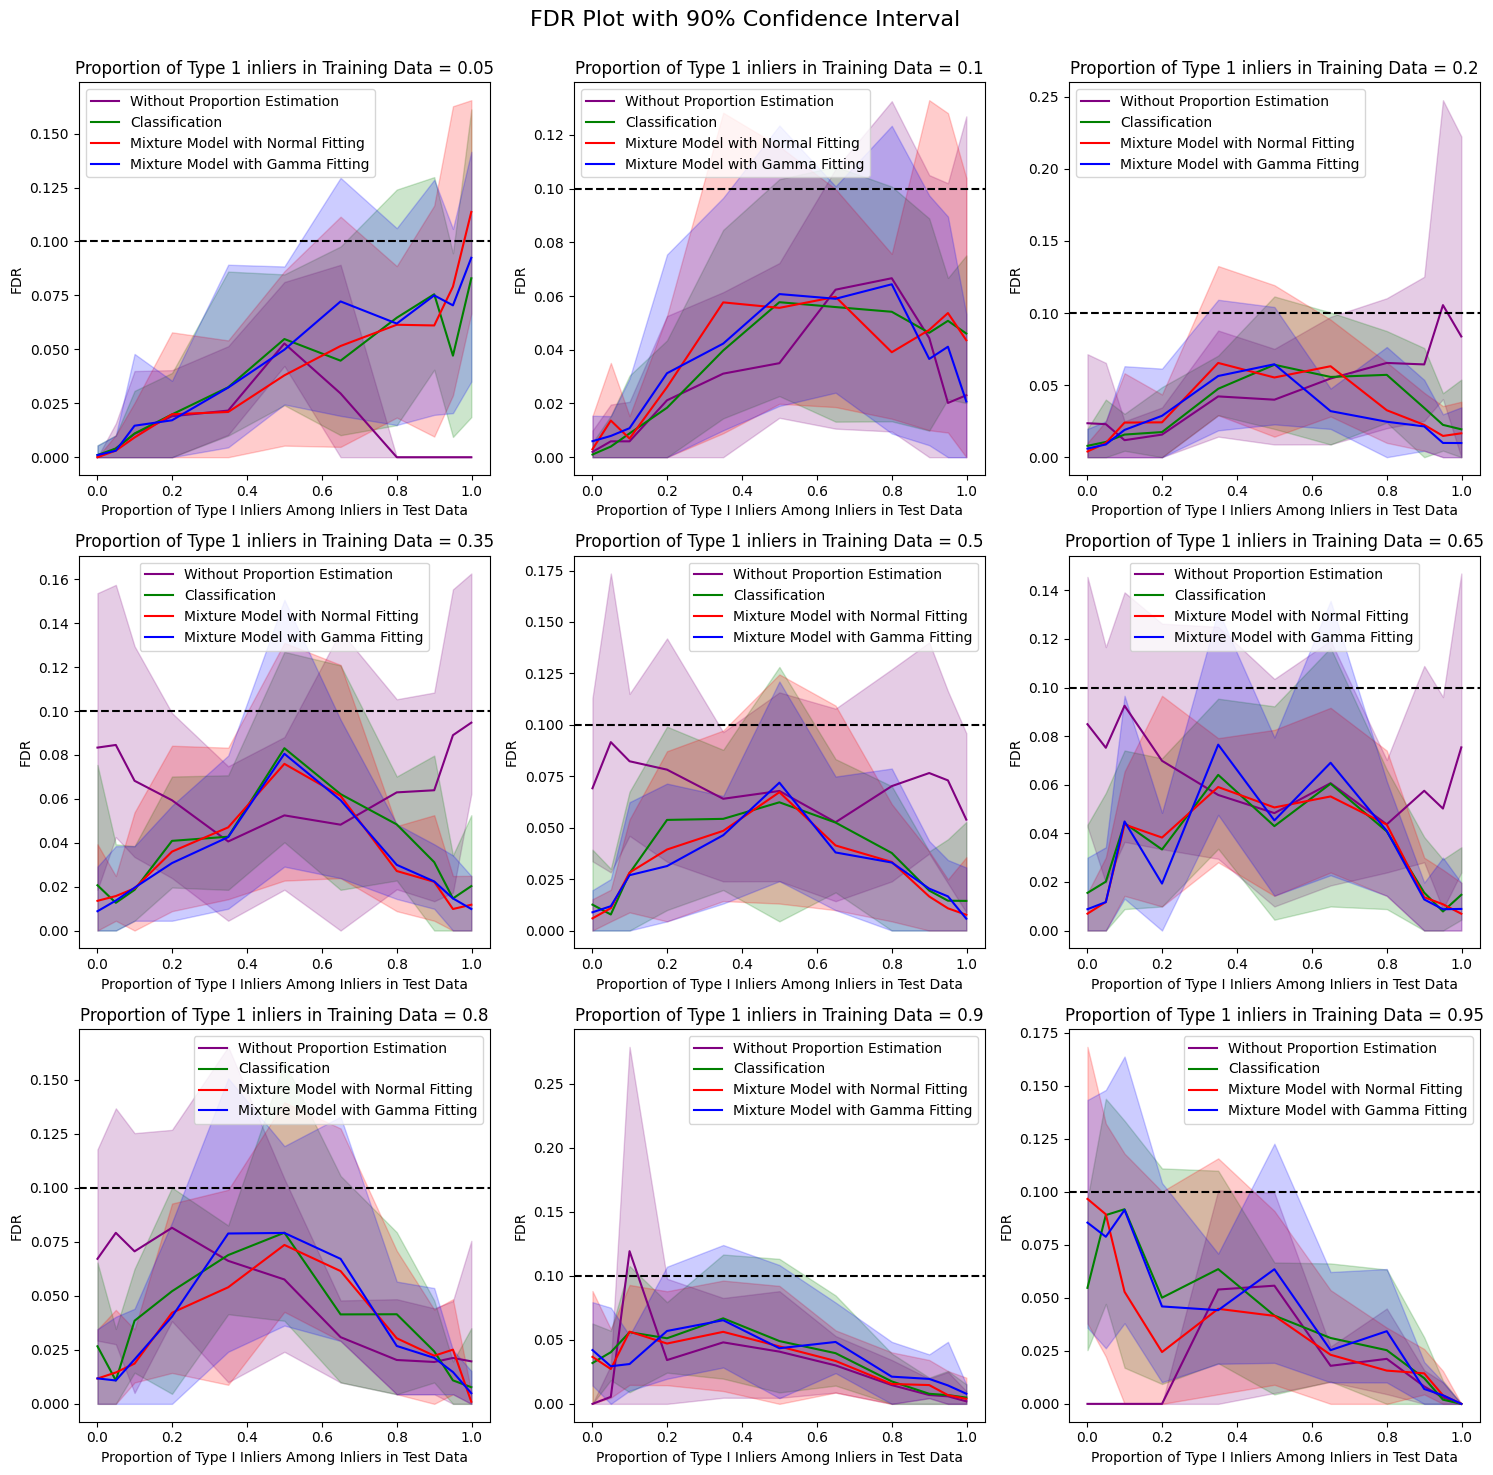

In [75]:
plt.figure(figsize=(15, 15))

for i, rho_value_train in enumerate(rho_values_train):
    plt.subplot(3, 3, i + 1)
    
    plt.plot(rho_values_test, mean_fdr[rho_value_train]['PE_free'], label='Without Proportion Estimation', color='purple', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_fdr[rho_value_train]['PE_free']], [ci[1] for ci in ci_fdr[rho_value_train]['PE_free']], color='purple', alpha=0.2)
    
    plt.plot(rho_values_test, mean_fdr[rho_value_train]['classification'], label='Classification', color='green', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_fdr[rho_value_train]['classification']], [ci[1] for ci in ci_fdr[rho_value_train]['classification']], color='green', alpha=0.2)
    
    plt.plot(rho_values_test, mean_fdr[rho_value_train]['normal'], label='Mixture Model with Normal Fitting', color='red', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_fdr[rho_value_train]['normal']], [ci[1] for ci in ci_fdr[rho_value_train]['normal']], color='red', alpha=0.2)
    
    plt.plot(rho_values_test, mean_fdr[rho_value_train]['gamma'], label='Mixture Model with Gamma Fitting', color='blue', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_fdr[rho_value_train]['gamma']], [ci[1] for ci in ci_fdr[rho_value_train]['gamma']], color='blue', alpha=0.2)
    
    plt.axhline(y=0.1, color='k', linestyle='--')
    
    plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
    plt.ylabel('FDR')
    plt.title(f'Proportion of Type 1 inliers in Training Data = {rho_value_train}')
    plt.legend()

plt.suptitle('FDR Plot with 90% Confidence Interval', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

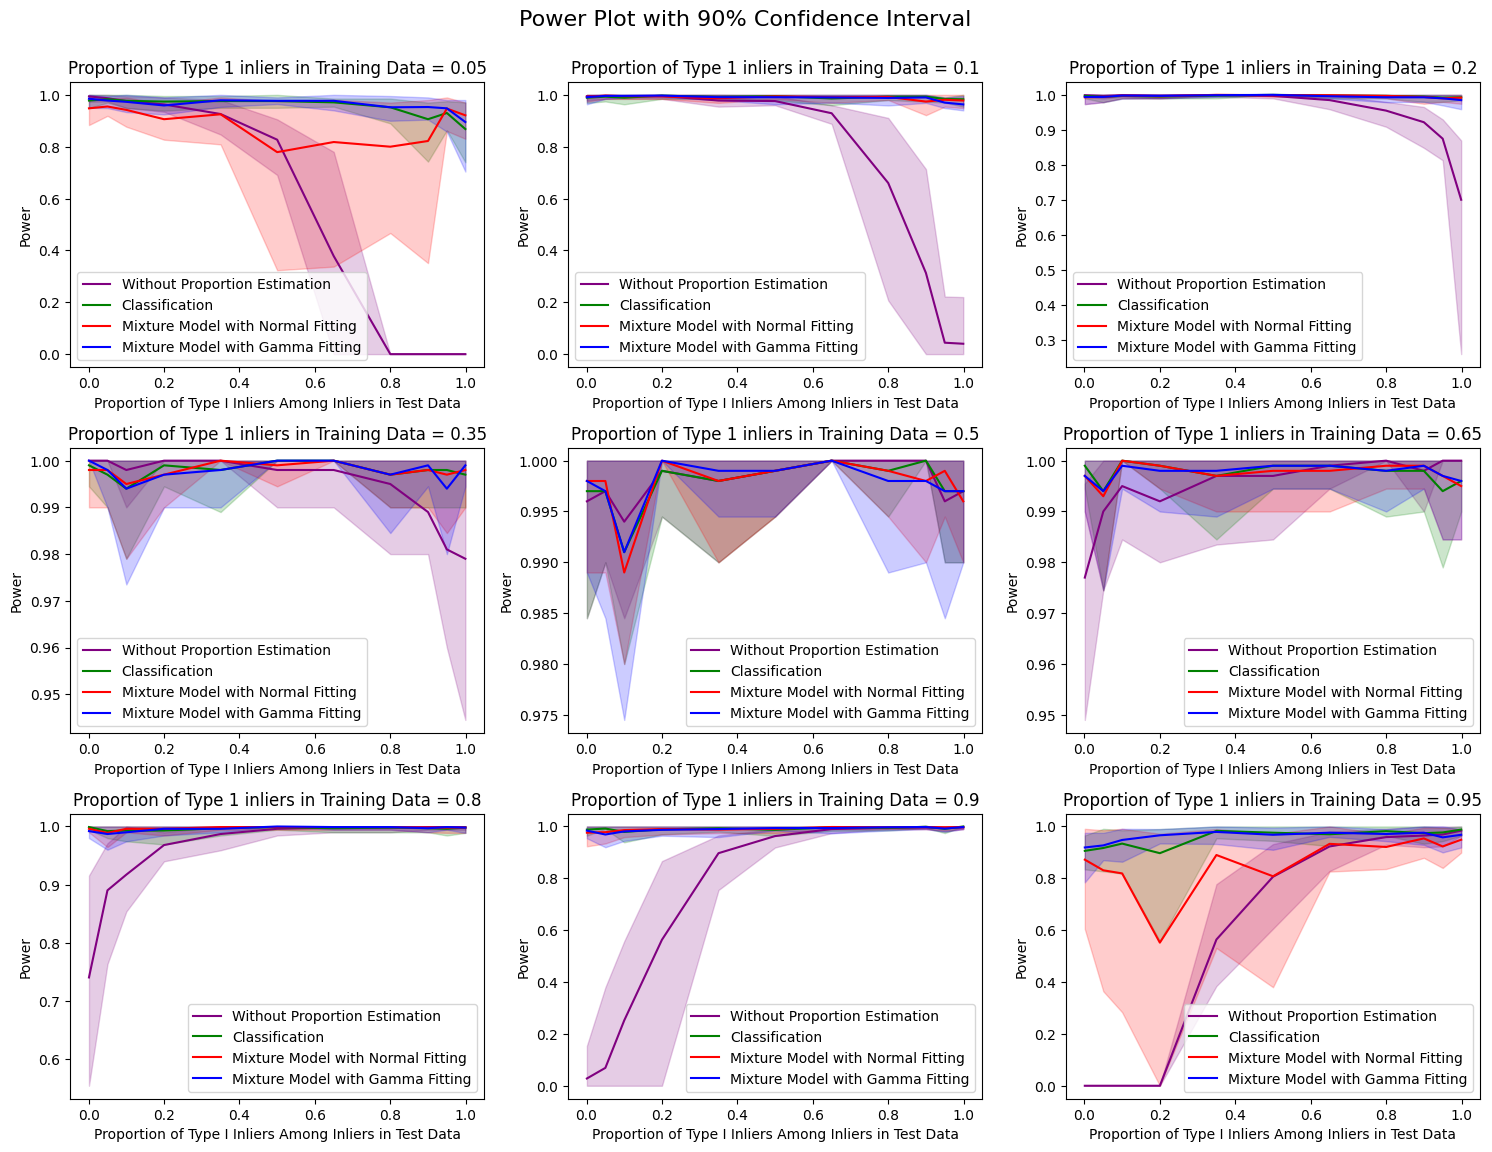

In [76]:
plt.figure(figsize=(15, 15))

for i, rho_value_train in enumerate(rho_values_train):
    plt.subplot(4, 3, i + 1)

    plt.plot(rho_values_test, mean_power[rho_value_train]['PE_free'], label='Without Proportion Estimation', color='purple', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_power[rho_value_train]['PE_free']], [ci[1] for ci in ci_power[rho_value_train]['PE_free']], color='purple', alpha=0.2)
    
    plt.plot(rho_values_test, mean_power[rho_value_train]['classification'], label='Classification', color='green', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_power[rho_value_train]['classification']], [ci[1] for ci in ci_power[rho_value_train]['classification']], color='green', alpha=0.2)
    
    plt.plot(rho_values_test, mean_power[rho_value_train]['normal'], label='Mixture Model with Normal Fitting', color='red', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_power[rho_value_train]['normal']], [ci[1] for ci in ci_power[rho_value_train]['normal']], color='red', alpha=0.2)
    
    plt.plot(rho_values_test, mean_power[rho_value_train]['gamma'], label='Mixture Model with Gamma Fitting', color='blue', linestyle='-')
    plt.fill_between(rho_values_test, [ci[0] for ci in ci_power[rho_value_train]['gamma']], [ci[1] for ci in ci_power[rho_value_train]['gamma']], color='blue', alpha=0.2)
    
    plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
    plt.ylabel('Power')
    plt.title(f'Proportion of Type 1 inliers in Training Data = {rho_value_train}')
    plt.legend()

plt.suptitle('Power Plot with 90% Confidence Interval', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Experiment Description:**   
- **Purpose:** Evaluate the impact of proportions of inliers in the training data
- **Experimental Design:** Range the proportion of type 1 inliers in test data from 0.001 to 0.999, change the proportion of type 1 inliers in training data from 0.05 to 0.95.
- **Methods:** Proportion Estimation Free(PE Free); Classification, Mixture Model using Normal Fitting and Gamma Fitting
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Data Shapes:** Uniform + Normal, with 50 dimensions
- **Size of Training Data:** 700
- **Size of Calibration Data:** [500, 500]
- **Size of Test Data:** 900 inliers and 100 outliers
  
- **Times of Iteration**: 10

Conclusion:
PE free methods depends highly on inlier proportions in the training data, only when inlier proprotions equal to half-half, PE free methods could have a high power

**Final Conclusion:** The only factor influncing PE method using mixture model is the size of training data(num of the least one type inliers in trainin g data, to be more precise)